<a href="https://colab.research.google.com/github/Dhruvil-sr24/Ecommerce-product-recommendation-system-project/blob/main/JSN_Amazon_product_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#E-commerce Product recommendation System
###Using Amazon - Ratings (Beauty Products) Dataset

###Importing libraries

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds # for sparse_matrices
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


###Importing Dataset

In [116]:
df=pd.read_csv('/content/drive/MyDrive/JSN_Comp_data/ratings_Beauty.csv')

In [117]:
df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


### EDA
checking shape, nullvalues and info about **data**

In [118]:
df.shape

(2023070, 4)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


###Missing value analysis

In [120]:
# Finding the number of missing values in each column
df.isna().sum()

,0
UserId,0
ProductId,0
Rating,0
Timestamp,0


In [121]:
#deleting Timestamp column
df.drop('Timestamp',axis=1,inplace=True)

###Summary

In [122]:
df.describe()

,Rating
count,2.023070e+06
mean,4.149036e+00
std,1.311505e+00
min,1.000000e+00
25%,4.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


###Rating distribution

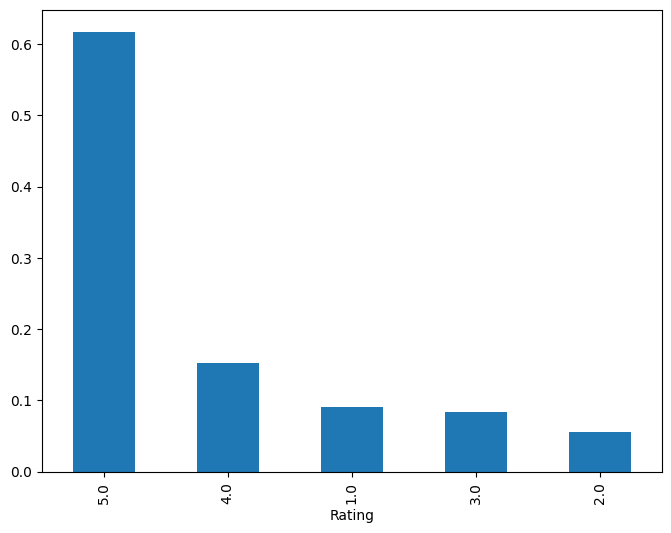

In [123]:
#Visualizing by bar chart

plt.figure(figsize = (8,6))
df['Rating'].value_counts(1).plot(kind='bar')
plt.show()

###Top product based on total ratings of that product

In [124]:
Total_rating_of_products = pd.DataFrame(df.groupby('ProductId')['Rating'].count())
Top_products = Total_rating_of_products.sort_values('Rating', ascending=False)
Top_products.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


<Axes: xlabel='ProductId'>

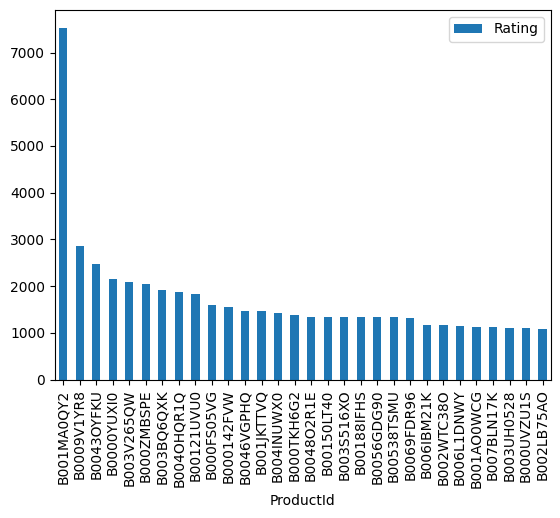

In [125]:
Top_products.head(30).plot(kind = "bar")


###Top users based on rating

In [126]:

most_rated = df.groupby('UserId').size().sort_values(ascending=False)[:]
most_rated.head(10)

,0
UserId,
A3KEZLJ59C1JVH,389
A281NPSIMI1C2R,336
A3M174IC0VXOS2,326
A2V5R832QCSOMX,278
A3LJLRIZL38GG3,276
ALQGOMOY1F5X9,275
AKMEY1BSHSDG7,269
A3R9H6OKZHHRJD,259
A1M04H40ZVGWVG,249


<Axes: xlabel='UserId'>

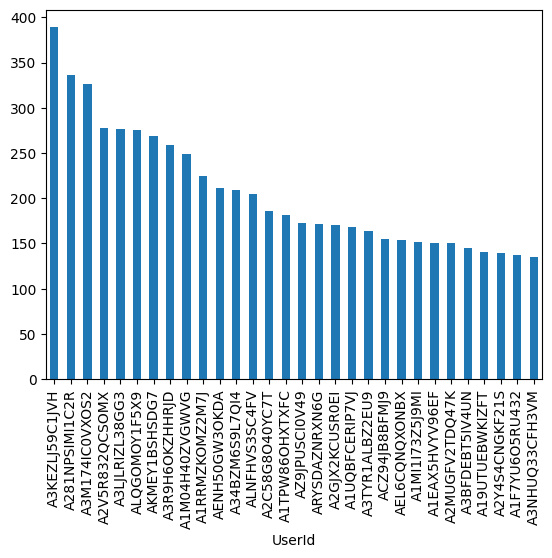

In [127]:
most_rated.head(30).plot(kind = "bar")


In [128]:
print("Total no. of unique product : ", df['ProductId'].nunique())
print("Total no. of unique user : ", df['UserId'].nunique())

Total no. of unique product :  249274
Total no. of unique user :  1210271


###**Pre Proccessing**

 Let's take a subset of the dataset (by only keeping the users who have given 30 or more ratings) to make the dataset less sparse and easy to work with.

In [129]:
counts = df['UserId'].value_counts()
df_final = df[df['UserId'].isin(counts[counts >= 30].index)]


In [130]:
df_final.shape

(58289, 3)

###Total no. of unique Product and Users

In [131]:
print("Total no. of unique product : ", df_final['ProductId'].nunique())
print("Total no. of unique user : ", df_final['UserId'].nunique())

Total no. of unique product :  28614
Total no. of unique user :  1136



*   The df_final has users who have rated 30 or more items
*   We will use df_final to build recommendation systems



###Checking the density of the rating matrix

In [132]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1136, 28614)
given_num_of_ratings =  58289
possible_num_of_ratings =  32505504
density: 0.18%


ProductId,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
UserId,,,,,,,,,,,,,,,,,,,,,
A03364251DGXSGA9PSR99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103979529MRJY0U56QI4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
# Calculate the average rating for each product
# Convert 'Rating' column to numeric, forcing non-numeric values to NaN
df_final['Rating'] = pd.to_numeric(df_final['Rating'], errors='coerce')

# Group by 'ProductId' and calculate the mean of 'Rating' for each group
# using the numeric values only
average_rating = df_final.groupby('ProductId')['Rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('ProductId')['Rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

# Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

final_rating.head(10)

,avg_rating,rating_count
ProductId,,
0762451459,5.0,1
B003SWVV8C,5.0,1
B003T16HLS,5.0,1
B003T12MHG,5.0,1
B003T01IAO,5.0,1
B003SZ8GW8,5.0,1
B003SZ6DUK,5.0,1
B003SYYEG6,5.0,1
B003SU590A,5.0,2


In [134]:

#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]

In [135]:
list(top_n_products(final_rating, 5, 10))

['B003QKH03Q', 'B0061KQG6K', 'B00IAMTLS2', 'B00G75X158', 'B00I4ZERGG']

In [136]:
list(top_n_products(final_rating, 5, 50))

['B00A0J09C0', 'B000E0K7NQ', 'B00AWLB9G6', 'B009YSSLAU', 'B00A0J09G6']

#Collaborative Filtering based Recommendation System
##User based collaborative filtering

In [137]:
final_ratings_matrix.head()

ProductId,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
UserId,,,,,,,,,,,,,,,,,,,,,
A03364251DGXSGA9PSR99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103979529MRJY0U56QI4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###Here UserId is string object so convert it to numbers

In [138]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

ProductId,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

In [140]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[173, 191, 233, 25, 973, 1014, 720, 406, 992, 824]

In [141]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.11142077]]),
 array([[0.10595625]]),
 array([[0.09610647]]),
 array([[0.08977601]]),
 array([[0.08327229]]),
 array([[0.07260818]]),
 array([[0.07147487]]),
 array([[0.05930774]]),
 array([[0.05319582]]),
 array([[0.0499904]])]

###Finding out top 10 similar users to the user index 1521 and their similarity score

In [142]:
similar = similar_users(9, final_ratings_matrix)[0][0:10]
similar

[225, 655, 582, 877, 910, 420, 494, 238, 975, 474]

In [143]:
#Print the similarity score
similar_users(9,final_ratings_matrix)[1][0:10]

[array([[0.0799181]]),
 array([[0.06665299]]),
 array([[0.04848389]]),
 array([[0.04466829]]),
 array([[0.04466829]]),
 array([[0.04337834]]),
 array([[0.0429186]]),
 array([[0.0402327]]),
 array([[0.04003753]]),
 array([[0.03984704]])]

In [144]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

In [145]:
recommendations(3,5,final_ratings_matrix)

['B003VMU63K', 'B004NMYM96', 'B006QO4BRM', 'B009EWZBTU', 'B00DZBWU04']

In [146]:
recommendations(9,5,final_ratings_matrix)

['B004KEQIPS', 'B000ZFI2PA', 'B00IJGK796', 'B008VHPM6Q', 'B003I5ZMDY']

#Model based Collaborative Filtering: Singular Value Decomposition
**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

Also, we will use **k=50 latent features** to predict rating of products

###CSR

In [147]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)

### Single Value Decomposition(SVD)

In [148]:
# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)


In [149]:
U.shape

(1136, 50)

In [150]:
sigma.shape

(50, 50)

In [151]:
Vt.shape

(50, 28614)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

###Predicting ratings


In [152]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
Pred_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
Pred_df.head()
Pred_matrix = csr_matrix(Pred_df.values)

###Function to recommend products

In [153]:
import numpy as np

def recommend_items(user_index, interactions_matrix, Pred_matrix, num_recommendations):

    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = Pred_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]

    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


In [154]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(121,final_ratings_sparse,Pred_matrix,5)


Below are the recommended products for user(user_id = 121):

Recommended Products
26430    3.183630
26318    3.172190
27584    3.023467
28460    2.884669
28457    2.523248
Name: user_predictions, dtype: float64


###Recommending top 10 products to user id 100

In [155]:
recommend_items(100,final_ratings_sparse,Pred_matrix,10)


Below are the recommended products for user(user_id = 100):

Recommended Products
19459    1.336344
22248    1.177926
20603    1.028571
21443    0.995042
9374     0.951789
21438    0.851119
1881     0.848476
21439    0.797005
21435    0.789439
23987    0.771304
Name: user_predictions, dtype: float64


### Evaluting the Model

In [156]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

ProductId,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

,0
ProductId,
0762451459,0.004401
1304139212,0.004401
130414643X,0.004401
1304174867,0.004401
1304174905,0.004401


In [158]:
Pred_df.head()

ProductId,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
0,0.005069,0.000099,0.000099,0.000099,0.000099,0.003139,0.000174,0.000174,0.000174,0.000174,...,0.009177,0.023532,0.000877,0.003577,0.018656,0.001171,0.000358,0.005622,0.006684,0.001300
1,0.005211,0.002065,0.002065,0.002065,0.002065,0.001717,0.000081,0.000081,0.000081,0.000081,...,0.022287,0.046916,0.003531,0.048237,0.044752,0.027955,0.000899,0.008091,0.121910,0.007751
2,0.002611,0.001122,0.001122,0.001122,0.001122,0.022428,0.000377,0.000377,0.000377,0.000377,...,0.035495,0.039869,0.002546,0.006257,0.051201,0.002422,0.029670,0.009414,0.027329,0.002143
3,0.009237,0.001281,0.001281,0.001281,0.001281,0.001826,0.000099,0.000099,0.000099,0.000099,...,0.018577,0.025621,0.001792,0.002068,0.127979,0.001347,0.003959,0.002134,0.001667,0.007852
4,0.000614,0.000049,0.000049,0.000049,0.000049,0.002340,0.000221,0.000221,0.000221,0.000221,...,0.009825,0.022786,0.000485,0.000843,0.005252,0.000453,0.000178,0.008465,0.001978,0.018570


In [159]:
avg_preds=Pred_df.mean()
avg_preds.head()

,0
ProductId,
0762451459,0.020790
1304139212,0.000404
130414643X,0.000404
1304174867,0.000404
1304174905,0.000404


In [160]:
RMSE_df = pd.concat([average_rating, avg_preds], axis=1)

RMSE_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

RMSE_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
ProductId,,
0762451459,0.004401,0.020790
1304139212,0.004401,0.000404
130414643X,0.004401,0.000404
1304174867,0.004401,0.000404
1304174905,0.004401,0.000404


In [161]:
RMSE=mean_squared_error(RMSE_df['Avg_actual_ratings'], RMSE_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.011968716830514337 

